In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, KFold, GridSearchCV, GroupKFold
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer as Imputer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from catboost import Pool, cv, CatBoostClassifier

from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             accuracy_score, roc_curve,
                             precision_recall_curve, f1_score, classification_report)
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.models import Model

In [2]:
def prepare_targets(y_train):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    return y_train_enc

In [3]:
def prepare_categorical_ordinal_inputs(X_train, categories=[]):
    if categories==[]:
        categories = 'auto'
        
    oe = OrdinalEncoder(categories)
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    
    return X_train_enc

In [79]:
data = pd.read_csv('Train.csv').set_index('Loan_ID')
data_test = pd.read_csv('Test.csv').set_index('Loan_ID')

In [5]:
print(f"{data.dtypes}\n")
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"{data.isnull().sum()}")
data.head()

Loan_Amount_Requested       object
Length_Employed             object
Home_Owner                  object
Annual_Income              float64
Income_Verified             object
Purpose_Of_Loan             object
Debt_To_Income             float64
Inquiries_Last_6Mo           int64
Months_Since_Deliquency    float64
Number_Open_Accounts         int64
Total_Accounts               int64
Gender                      object
Interest_Rate                int64
dtype: object

Sum of null values in each feature:
-----------------------------------
Loan_Amount_Requested          0
Length_Employed             7371
Home_Owner                 25349
Annual_Income              25102
Income_Verified                0
Purpose_Of_Loan                0
Debt_To_Income                 0
Inquiries_Last_6Mo             0
Months_Since_Deliquency    88379
Number_Open_Accounts           0
Total_Accounts                 0
Gender                         0
Interest_Rate                  0
dtype: int64


Loan_Amount_Requested Length_Employed Home_Owner  Annual_Income  \
Loan_ID                                                                    
10000001                 7,000        < 1 year       Rent        68000.0   
10000002                30,000         4 years   Mortgage            NaN   
10000003                24,725         7 years   Mortgage        75566.4   
10000004                16,000        < 1 year        NaN        56160.0   
10000005                17,000         8 years        Own        96000.0   

                   Income_Verified     Purpose_Of_Loan  Debt_To_Income  \
Loan_ID                                                                  
10000001              not verified                 car           18.37   
10000002         VERIFIED - income  debt_consolidation           14.93   
10000003  VERIFIED - income source  debt_consolidation           15.88   
10000004  VERIFIED - income source  debt_consolidation           14.34   
10000005  VERIFIED - income source  debt_consolidation           22.17   

          Inquiries_Last_6Mo  Months_Since_Deliquency  Number_Open_Accounts  \
Loan_ID                                                                       
10000001                   0                      NaN                     9   
10000002                   0                     17.0                    12   
10000003                   0                      NaN                    12   
10000004                   3                      NaN                    16   
10000005                   1                      NaN                    19   

          Total_Accounts  Gender  Interest_Rate  
Loan_ID                                          
10000001              14  Female              1  
10000002              24  Female              3  
10000003              16    Male              3  
10000004              22    Male              3  
10000005              30  Female              1

In [6]:
data['Interest_Rate'].value_counts()

2    70580
3    59923
1    33806
Name: Interest_Rate, dtype: int64

# Preprocess data

## Target

In [7]:
data.loc[:,'Interest_Rate'] = prepare_targets(data['Interest_Rate'].values)

## Numerical

In [8]:
numerical_features = [
    'Loan_Amount_Requested',
    'Annual_Income',
    'Debt_To_Income',
    'Inquiries_Last_6Mo',
    'Months_Since_Deliquency',
    'Number_Open_Accounts',
    'Total_Accounts'
]

In [9]:
data.loc[:, 'Loan_Amount_Requested'] = data['Loan_Amount_Requested'].apply(lambda x: int(x.replace(',','')))
data_test.loc[:, 'Loan_Amount_Requested'] = data_test['Loan_Amount_Requested'].apply(lambda x: int(x.replace(',','')))

In [10]:
data[numerical_features] = data[numerical_features].fillna(-99)
data_test[numerical_features] = data_test[numerical_features].fillna(-99)

In [11]:
data[numerical_features].isnull().sum()

Loan_Amount_Requested      0
Annual_Income              0
Debt_To_Income             0
Inquiries_Last_6Mo         0
Months_Since_Deliquency    0
Number_Open_Accounts       0
Total_Accounts             0
dtype: int64

In [12]:
data[numerical_features]

Loan_Amount_Requested  Annual_Income  Debt_To_Income  \
Loan_ID                                                          
10000001                   7000        68000.0           18.37   
10000002                  30000          -99.0           14.93   
10000003                  24725        75566.4           15.88   
10000004                  16000        56160.0           14.34   
10000005                  17000        96000.0           22.17   
...                         ...            ...             ...   
10164305                  20725          -99.0           13.56   
10164306                   6000          -99.0            9.12   
10164307                  20250          -99.0           18.17   
10164308                  10000          -99.0           18.75   
10164309                   9250          -99.0           19.44   

          Inquiries_Last_6Mo  Months_Since_Deliquency  Number_Open_Accounts  \
Loan_ID                                                                       
10000001                   0                    -99.0                     9   
10000002                   0                     17.0                    12   
10000003                   0                    -99.0                    12   
10000004                   3                    -99.0                    16   
10000005                   1                    -99.0                    19   
...                      ...                      ...                   ...   
10164305                   0                    -99.0                    13   
10164306                   0                     36.0                    13   
10164307                   1                    -99.0                    17   
10164308                   1                     48.0                    16   
10164309                   1                    -99.0                     5   

          Total_Accounts  
Loan_ID                   
10000001              14  
10000002              24  
10000003              16  
10000004              22  
10000005              30  
...                  ...  
10164305              16  
10164306              30  
10164307              30  
10164308              62  
10164309               9  

[164309 rows x 7 columns]

## Categorical

#### Home_Owner

In [13]:
categorical_features = [
    'Length_Employed',
    'Home_Owner',
    'Income_Verified',
    'Purpose_Of_Loan',
    'Gender'
]

In [14]:
data[categorical_features] = data[categorical_features].fillna('-99')
data['Home_Owner'].replace('None', '-99', inplace=True)
data['Home_Owner'].replace('Other', '-99', inplace=True)

In [15]:
data_test[categorical_features] = data_test[categorical_features].fillna('-99')
data_test['Home_Owner'].replace('None', '-99', inplace=True)
data_test['Home_Owner'].replace('Other', '-99', inplace=True)

#### Length_Employed

In [16]:
data.loc[:,'Length_Employed'] = prepare_categorical_ordinal_inputs(data['Length_Employed'].values.reshape(-1, 1), 
                                                                   [['< 1 year','1 year','2 years','3 years','4 years','5 years','6 years','7 years','8 years','9 years','10+ years','-99']])
data['Length_Employed'].replace(11, -99, inplace=True)
data['Length_Employed'] = data['Length_Employed'].astype('int')

/home/reza/env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass categories=[['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years', '-99']] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [17]:
data_test.loc[:,'Length_Employed'] = prepare_categorical_ordinal_inputs(data_test['Length_Employed'].values.reshape(-1, 1), 
                                                                   [['< 1 year','1 year','2 years','3 years','4 years','5 years','6 years','7 years','8 years','9 years','10+ years','-99']])
data_test['Length_Employed'].replace(11, -99, inplace=True)
data_test['Length_Employed'] = data_test['Length_Employed'].astype('int')

/home/reza/env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass categories=[['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years', '-99']] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [18]:
data[categorical_features].isnull().sum()

Length_Employed    0
Home_Owner         0
Income_Verified    0
Purpose_Of_Loan    0
Gender             0
dtype: int64

In [19]:
for feature in categorical_features:
    print(data[feature].unique())

[  0   4   7   8   2  10   1 -99   6   9   3   5]
['Rent' 'Mortgage' '-99' 'Own']
['not verified' 'VERIFIED - income' 'VERIFIED - income source']
['car' 'debt_consolidation' 'credit_card' 'home_improvement'
 'major_purchase' 'other' 'medical' 'small_business' 'moving' 'wedding'
 'vacation' 'house' 'educational' 'renewable_energy']
['Female' 'Male']


In [20]:
data[categorical_features]

Length_Employed Home_Owner           Income_Verified  \
Loan_ID                                                          
10000001                0       Rent              not verified   
10000002                4   Mortgage         VERIFIED - income   
10000003                7   Mortgage  VERIFIED - income source   
10000004                0        -99  VERIFIED - income source   
10000005                8        Own  VERIFIED - income source   
...                   ...        ...                       ...   
10164305               10       Rent  VERIFIED - income source   
10164306                8        Own  VERIFIED - income source   
10164307               10   Mortgage         VERIFIED - income   
10164308                4       Rent              not verified   
10164309               10       Rent         VERIFIED - income   

             Purpose_Of_Loan  Gender  
Loan_ID                               
10000001                 car  Female  
10000002  debt_consolidation  Female  
10000003  debt_consolidation    Male  
10000004  debt_consolidation    Male  
10000005  debt_consolidation  Female  
...                      ...     ...  
10164305         credit_card    Male  
10164306      small_business    Male  
10164307         credit_card    Male  
10164308      major_purchase  Female  
10164309         credit_card  Female  

[164309 rows x 5 columns]

# Exploratory data analysis

In [21]:
print(f"{data.dtypes}\n")
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"{data.isnull().sum()}")
data.head()

Loan_Amount_Requested        int64
Length_Employed              int64
Home_Owner                  object
Annual_Income              float64
Income_Verified             object
Purpose_Of_Loan             object
Debt_To_Income             float64
Inquiries_Last_6Mo           int64
Months_Since_Deliquency    float64
Number_Open_Accounts         int64
Total_Accounts               int64
Gender                      object
Interest_Rate                int64
dtype: object

Sum of null values in each feature:
-----------------------------------
Loan_Amount_Requested      0
Length_Employed            0
Home_Owner                 0
Annual_Income              0
Income_Verified            0
Purpose_Of_Loan            0
Debt_To_Income             0
Inquiries_Last_6Mo         0
Months_Since_Deliquency    0
Number_Open_Accounts       0
Total_Accounts             0
Gender                     0
Interest_Rate              0
dtype: int64


Loan_Amount_Requested  Length_Employed Home_Owner  Annual_Income  \
Loan_ID                                                                      
10000001                   7000                0       Rent        68000.0   
10000002                  30000                4   Mortgage          -99.0   
10000003                  24725                7   Mortgage        75566.4   
10000004                  16000                0        -99        56160.0   
10000005                  17000                8        Own        96000.0   

                   Income_Verified     Purpose_Of_Loan  Debt_To_Income  \
Loan_ID                                                                  
10000001              not verified                 car           18.37   
10000002         VERIFIED - income  debt_consolidation           14.93   
10000003  VERIFIED - income source  debt_consolidation           15.88   
10000004  VERIFIED - income source  debt_consolidation           14.34   
10000005  VERIFIED - income source  debt_consolidation           22.17   

          Inquiries_Last_6Mo  Months_Since_Deliquency  Number_Open_Accounts  \
Loan_ID                                                                       
10000001                   0                    -99.0                     9   
10000002                   0                     17.0                    12   
10000003                   0                    -99.0                    12   
10000004                   3                    -99.0                    16   
10000005                   1                    -99.0                    19   

          Total_Accounts  Gender  Interest_Rate  
Loan_ID                                          
10000001              14  Female              0  
10000002              24  Female              2  
10000003              16    Male              2  
10000004              22    Male              2  
10000005              30  Female              0

In [22]:
print(f"{data_test.dtypes}\n")
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"{data_test.isnull().sum()}")
data_test.head()

Loan_Amount_Requested        int64
Length_Employed              int64
Home_Owner                  object
Annual_Income              float64
Income_Verified             object
Purpose_Of_Loan             object
Debt_To_Income             float64
Inquiries_Last_6Mo           int64
Months_Since_Deliquency    float64
Number_Open_Accounts         int64
Total_Accounts               int64
Gender                      object
dtype: object

Sum of null values in each feature:
-----------------------------------
Loan_Amount_Requested      0
Length_Employed            0
Home_Owner                 0
Annual_Income              0
Income_Verified            0
Purpose_Of_Loan            0
Debt_To_Income             0
Inquiries_Last_6Mo         0
Months_Since_Deliquency    0
Number_Open_Accounts       0
Total_Accounts             0
Gender                     0
dtype: int64


Loan_Amount_Requested  Length_Employed Home_Owner  Annual_Income  \
Loan_ID                                                                      
10164310                  27500               10   Mortgage       129000.0   
10164311                  26000               10        -99       110000.0   
10164312                   6075                0       Rent        75000.0   
10164313                  12000               10   Mortgage        73000.0   
10164314                  35000                0   Mortgage       156000.0   

                   Income_Verified     Purpose_Of_Loan  Debt_To_Income  \
Loan_ID                                                                  
10164310         VERIFIED - income  debt_consolidation           12.87   
10164311              not verified         credit_card           11.37   
10164312         VERIFIED - income  debt_consolidation            6.83   
10164313  VERIFIED - income source  debt_consolidation            7.76   
10164314              not verified  debt_consolidation            9.62   

          Inquiries_Last_6Mo  Months_Since_Deliquency  Number_Open_Accounts  \
Loan_ID                                                                       
10164310                   0                     68.0                    10   
10164311                   0                    -99.0                     6   
10164312                   2                    -99.0                     5   
10164313                   0                    -99.0                     6   
10164314                   0                     26.0                     9   

          Total_Accounts Gender  
Loan_ID                          
10164310              37   Male  
10164311              23   Male  
10164312              20   Male  
10164313               8   Male  
10164314              21   Male

In [23]:
df = data.append(data_test)

In [24]:
df

Loan_Amount_Requested  Length_Employed Home_Owner  Annual_Income  \
Loan_ID                                                                      
10000001                   7000                0       Rent        68000.0   
10000002                  30000                4   Mortgage          -99.0   
10000003                  24725                7   Mortgage        75566.4   
10000004                  16000                0        -99        56160.0   
10000005                  17000                8        Own        96000.0   
...                         ...              ...        ...            ...   
10273846                  15000                9   Mortgage       120000.0   
10273847                   9600               10   Mortgage       125000.0   
10273848                   2000                5       Rent        37850.0   
10273849                   2125                6       Rent        30000.0   
10273850                  15000                2   Mortgage       137000.0   

                   Income_Verified     Purpose_Of_Loan  Debt_To_Income  \
Loan_ID                                                                  
10000001              not verified                 car           18.37   
10000002         VERIFIED - income  debt_consolidation           14.93   
10000003  VERIFIED - income source  debt_consolidation           15.88   
10000004  VERIFIED - income source  debt_consolidation           14.34   
10000005  VERIFIED - income source  debt_consolidation           22.17   
...                            ...                 ...             ...   
10273846         VERIFIED - income               other            8.15   
10273847              not verified         credit_card            9.08   
10273848              not verified         credit_card           11.60   
10273849              not verified               other           24.88   
10273850              not verified             medical            8.66   

          Inquiries_Last_6Mo  Months_Since_Deliquency  Number_Open_Accounts  \
Loan_ID                                                                       
10000001                   0                    -99.0                     9   
10000002                   0                     17.0                    12   
10000003                   0                    -99.0                    12   
10000004                   3                    -99.0                    16   
10000005                   1                    -99.0                    19   
...                      ...                      ...                   ...   
10273846                   2                     32.0                    13   
10273847                   1                     17.0                     9   
10273848                   0                    -99.0                    10   
10273849                   0                    -99.0                     5   
10273850                   1                     60.0                     8   

          Total_Accounts  Gender  Interest_Rate  
Loan_ID                                          
10000001              14  Female            0.0  
10000002              24  Female            2.0  
10000003              16    Male            2.0  
10000004              22    Male            2.0  
10000005              30  Female            0.0  
...                  ...     ...            ...  
10273846              57    Male            NaN  
10273847              34    Male            NaN  
10273848              11    Male            NaN  
10273849               6    Male            NaN  
10273850              17    Male            NaN  

[273850 rows x 13 columns]

## Loan_Amount_Requested

In [25]:
print(f"skewness: {df['Loan_Amount_Requested'].skew()}")
print(f"kurtosis: {df['Loan_Amount_Requested'].kurtosis()}")
print(f"min: {df['Loan_Amount_Requested'].min()}")
print(f"max: {df['Loan_Amount_Requested'].max()}")
sns.distplot(df['Loan_Amount_Requested'])

skewness: 0.7281711914648847
kurtosis: -0.14193414872041377
min: 500
max: 35000


/home/reza/env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Loan_Amount_Requested', ylabel='Density'>

<AxesSubplot:title={'center':'Loan_Amount_Requested'}, xlabel='Interest_Rate'>

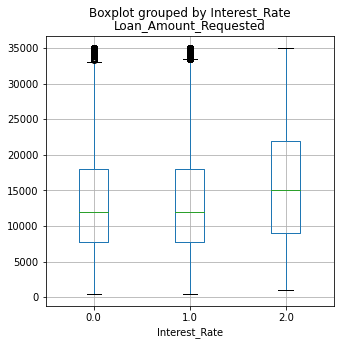

In [26]:
fig, ax = plt.subplots(figsize=(5,5))
plt.suptitle('')
df.boxplot(column=['Loan_Amount_Requested'], by='Interest_Rate', ax=ax)

In [27]:
df['Loan_Amount_Requested_bin'] = pd.cut(df['Loan_Amount_Requested'], bins= 3, labels=['Low','Medium','High'], right=True)
pivot = pd.pivot_table(df.reset_index(), index=["Loan_Amount_Requested_bin"], columns=['Interest_Rate'], values="Loan_ID", aggfunc="count")
pivot['total'] = pivot[0]+pivot[1]+pivot[2]
pivot['0_perc'] = pivot[0]/pivot['total']
pivot['1_perc'] = pivot[1]/pivot['total']
pivot['2_perc'] = pivot[2]/pivot['total']
pivot

Interest_Rate                0.0    1.0    2.0  total    0_perc    1_perc  \
Loan_Amount_Requested_bin                                                   
Low                        18301  38679  25104  82084  0.222955  0.471212   
Medium                     11305  23002  21239  55546  0.203525  0.414107   
High                        4200   8899  13580  26679  0.157427  0.333558   

Interest_Rate                2_perc  
Loan_Amount_Requested_bin            
Low                        0.305833  
Medium                     0.382368  
High                       0.509015

In [28]:
df.loc[:,'Loan_Amount_Requested_bin'] = prepare_categorical_ordinal_inputs(
                                                        df['Loan_Amount_Requested_bin'].astype('str').values.reshape(-1, 1), 
                                                        [['Low','Medium','High']])
df['Loan_Amount_Requested_bin'] = df['Loan_Amount_Requested_bin'].astype('int')

/home/reza/env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass categories=[['Low', 'Medium', 'High']] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


## Length_Employed

In [29]:
df['Length_Employed'].value_counts()

 10    88328
 2     24420
 3     21478
 0     21133
 5     18042
 1     17336
 4     16393
 7     15444
 6     15351
 8     13115
-99    12307
 9     10503
Name: Length_Employed, dtype: int64

In [30]:
df['Length_Employed_bin'] = pd.cut(df['Length_Employed'], [-np.inf, -99, 2, 5, 7, 9, np.inf], labels=['-99','0-2 years','3-5 years','6-7 years','8-9 years','10'], right=True)
pivot = pd.pivot_table(df.reset_index(), index=["Length_Employed_bin"], columns=['Interest_Rate'], values="Loan_ID", aggfunc="count")
pivot['total'] = pivot[0]+pivot[1]+pivot[2]
pivot['0_perc'] = pivot[0]/pivot['total']
pivot['1_perc'] = pivot[1]/pivot['total']
pivot['2_perc'] = pivot[2]/pivot['total']
pivot

Interest_Rate          0.0    1.0    2.0  total    0_perc    1_perc    2_perc
Length_Employed_bin                                                          
-99                   1409   3172   2790   7371  0.191155  0.430335  0.378510
0-2 years             8233  16637  12977  37847  0.217534  0.439586  0.342881
3-5 years             7150  14445  11977  33572  0.212975  0.430269  0.356756
6-7 years             3599   7853   6950  18402  0.195577  0.426747  0.377676
8-9 years             2819   6144   5239  14202  0.198493  0.432615  0.368892
10                   10596  22329  19990  52915  0.200246  0.421979  0.377776

In [31]:
df.loc[:,'Length_Employed_bin'] = prepare_categorical_ordinal_inputs(
                                                        df['Length_Employed_bin'].astype('str').values.reshape(-1, 1), 
                                                        [['-99','0-2 years','3-5 years','6-7 years','8-9 years','10']])
df['Length_Employed_bin'] = df['Length_Employed_bin'].astype('int')

/home/reza/env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass categories=[['-99', '0-2 years', '3-5 years', '6-7 years', '8-9 years', '10']] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


## Home_Owner

In [32]:
df['Home_Owner'].value_counts()

Mortgage    117270
Rent         93542
-99          42159
Own          20879
Name: Home_Owner, dtype: int64

In [33]:
pivot = pd.pivot_table(df.reset_index(), index=["Home_Owner"], columns=['Interest_Rate'], values="Loan_ID", aggfunc="count")
pivot['total'] = pivot[0]+pivot[1]+pivot[2]
pivot['0_perc'] = pivot[0]/pivot['total']
pivot['1_perc'] = pivot[1]/pivot['total']
pivot['2_perc'] = pivot[2]/pivot['total']
pivot

Interest_Rate    0.0    1.0    2.0  total    0_perc    1_perc    2_perc
Home_Owner                                                             
-99             5234  10838   9336  25408  0.205998  0.426559  0.367443
Mortgage       16365  29689  24291  70345  0.232639  0.422048  0.345312
Own             2488   5416   4621  12525  0.198643  0.432415  0.368942
Rent            9719  24637  21675  56031  0.173458  0.439703  0.386839

## Annual_Income

In [34]:
print(f"skewness: {df['Annual_Income'].skew()}")
print(f"kurtosis: {df['Annual_Income'].kurtosis()}")
print(f"min: {df['Annual_Income'].min()}")
print(f"max: {df['Annual_Income'].max()}")
sns.distplot(df['Annual_Income'])

skewness: 29.24335287279749
kurtosis: 2948.924436782399
min: -99.0
max: 7500000.0


/home/reza/env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Annual_Income', ylabel='Density'>

In [35]:
df['Annual_Income'].replace(-99, np.NaN, inplace = True)
df['Annual_Income'].fillna(df['Annual_Income'].median(),inplace = True)

In [36]:
df["Number_Years_To_Repay_Debt"] = df["Loan_Amount_Requested"]/df["Annual_Income"]

## Income_Verified

In [37]:
df['Income_Verified'].value_counts()

VERIFIED - income           99076
VERIFIED - income source    88253
not verified                86521
Name: Income_Verified, dtype: int64

## Purpose_Of_Loan

In [38]:
df['Purpose_Of_Loan'].value_counts()

debt_consolidation    161403
credit_card            61394
home_improvement       15455
other                  13846
major_purchase          5712
small_business          4064
car                     3149
medical                 2633
moving                  1675
vacation                1453
wedding                 1345
house                   1316
renewable_energy         206
educational              199
Name: Purpose_Of_Loan, dtype: int64

## Debt_To_Income

skewness: 0.19213205369155806
kurtosis: -0.5382642536274256
min: 0.0
max: 39.99


/home/reza/env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Debt_To_Income', ylabel='Density'>

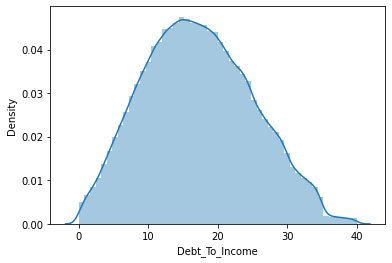

In [39]:
print(f"skewness: {df['Debt_To_Income'].skew()}")
print(f"kurtosis: {df['Debt_To_Income'].kurtosis()}")
print(f"min: {df['Debt_To_Income'].min()}")
print(f"max: {df['Debt_To_Income'].max()}")
sns.distplot(df['Debt_To_Income'])

## Inquiries_Last_6Mo

/home/reza/env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Inquiries_Last_6Mo', ylabel='count'>

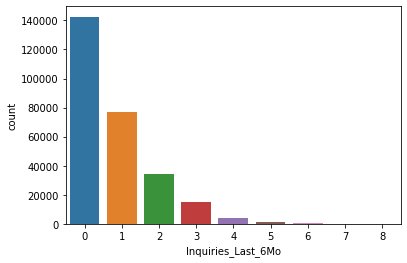

In [40]:
sns.countplot(df['Inquiries_Last_6Mo'])

## Months_Since_Deliquency

In [41]:
df['Months_Since_Deliquency'].value_counts()

-99.0     147238
 9.0        2585
 8.0        2515
 13.0       2496
 12.0       2473
           ...  
 140.0         1
 143.0         1
 148.0         1
 124.0         1
 127.0         1
Name: Months_Since_Deliquency, Length: 133, dtype: int64

## Number_Open_Accounts

skewness: 1.1610277257047426
kurtosis: 2.808239026114249
min: 0
max: 84


/home/reza/env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Number_Open_Accounts', ylabel='Density'>

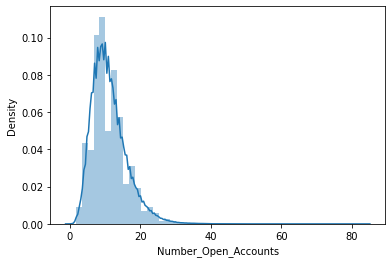

In [42]:
print(f"skewness: {df['Number_Open_Accounts'].skew()}")
print(f"kurtosis: {df['Number_Open_Accounts'].kurtosis()}")
print(f"min: {df['Number_Open_Accounts'].min()}")
print(f"max: {df['Number_Open_Accounts'].max()}")
sns.distplot(df['Number_Open_Accounts'])

In [43]:
df['Number_Closed_Accounts'] = df['Total_Accounts'] - df['Number_Open_Accounts']

## Total_Accounts

skewness: 0.8197533059289299
kurtosis: 0.9421636243406386
min: 2
max: 156


/home/reza/env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Total_Accounts', ylabel='Density'>

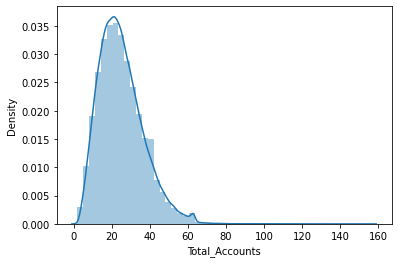

In [44]:
print(f"skewness: {df['Total_Accounts'].skew()}")
print(f"kurtosis: {df['Total_Accounts'].kurtosis()}")
print(f"min: {df['Total_Accounts'].min()}")
print(f"max: {df['Total_Accounts'].max()}")
sns.distplot(df['Total_Accounts'])

## Gender

In [45]:
df['Gender'].value_counts()

Male      194993
Female     78857
Name: Gender, dtype: int64

In [46]:
df.columns

Index(['Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Annual_Income', 'Income_Verified', 'Purpose_Of_Loan', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Number_Open_Accounts',
       'Total_Accounts', 'Gender', 'Interest_Rate',
       'Loan_Amount_Requested_bin', 'Length_Employed_bin',
       'Number_Years_To_Repay_Debt', 'Number_Closed_Accounts'],
      dtype='object')

<AxesSubplot:>

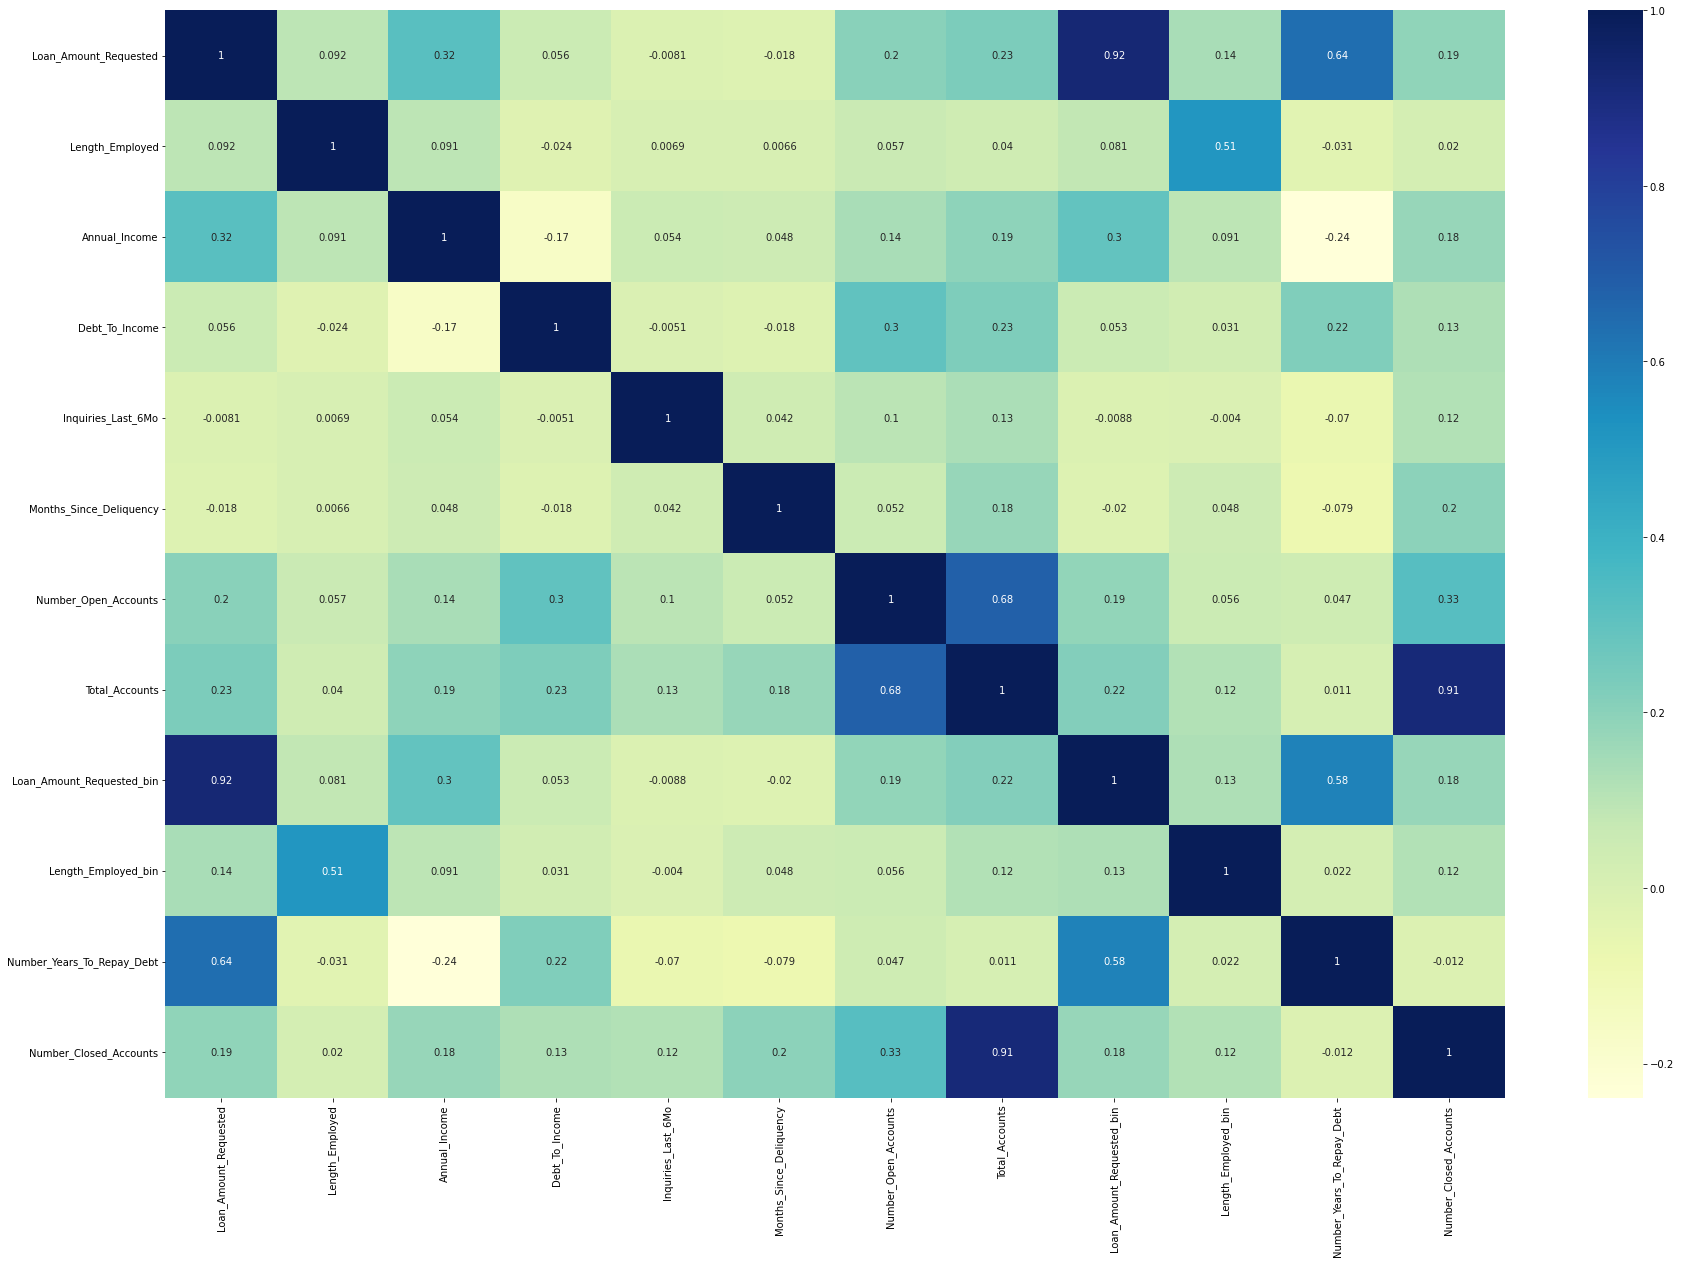

In [47]:
corrMatrix = df.loc[:, df.columns != "Interest_Rate"].corr()
plt.figure(figsize=(30,20))
sns.heatmap(corrMatrix, annot=True, cmap="YlGnBu")

In [48]:
trains = df[df['Interest_Rate'].isna() == False] 
tests = df[df['Interest_Rate'].isna() == True]

# Insights from Data

In [49]:
trains.groupby('Length_Employed')['Loan_Amount_Requested'].agg(['count','min','max','mean','median','std'])

count   min    max          mean   median          std
Length_Employed                                                        
-99               7371  1000  35000  11493.108126  10000.0  7447.149916
 0               12805   500  35000  13073.049590  11200.0  8065.617881
 1               10422   725  35000  13242.355114  11500.0  7980.595155
 2               14620   800  35000  13592.093023  12000.0  8067.727029
 3               12974   500  35000  13699.460459  12000.0  8011.624766
 4                9784   900  35000  13733.130621  12000.0  7972.669287
 5               10814  1000  35000  13850.906233  12000.0  8043.100489
 6                9094  1000  35000  14103.216406  12000.0  8004.244626
 7                9308  1000  35000  14439.637946  12762.5  8068.943753
 8                7917  1000  35000  14517.361374  12975.0  8135.982141
 9                6285  1000  35000  14850.688146  13475.0  8117.239122
 10              52915  1000  35000  15800.171974  15000.0  8589.973933

1. Mean Loan_Amount_Requested is highest for people with 10+ years of experience.
2. Mean Loan_Amount_Requested is lowest for people with <1 year of being employed.
3. If following the pattern of mean Loan_Amount_Requested, the missing value can be assume as unemployed population

In [50]:
trains.groupby('Home_Owner')['Loan_Amount_Requested'].agg(['count','min','max','mean','median','std'])

count  min    max          mean  median          std
Home_Owner                                                      
-99         25408  950  35000  14255.598630   12000  8220.030982
Mortgage    70345  500  35000  16040.132206   15000  8624.636937
Own         12525  900  35000  13567.704591   12000  8135.510763
Rent        56031  500  35000  12443.831986   10625  7413.272921

Average Loan_Amount_Requested is maximum for people with Home_Owner status as Mortgage.

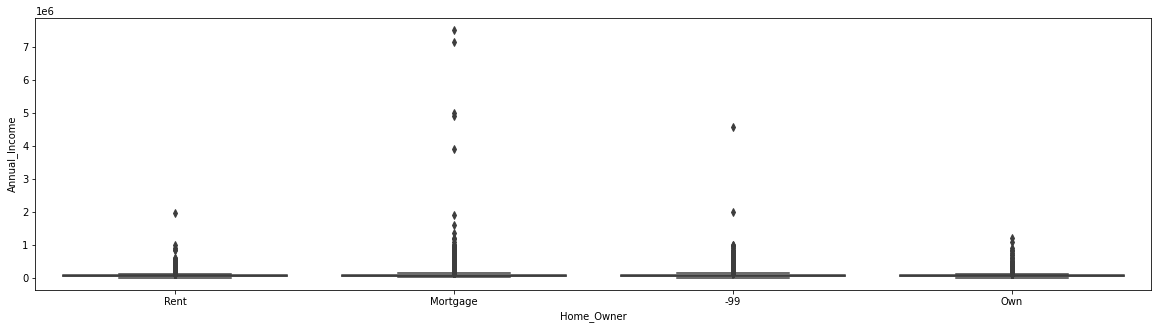

In [51]:
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.boxplot(x='Home_Owner', y="Annual_Income", data=trains, ax=ax)
plt.show()

The economy from which the data was extracted, namely it is likely not a savings based economy. You can tell this by looking at how people who own their houses are not that much wealthier than those who have it on a mortgage. This implies that even when induviudals have enough income to perhaps save an eventually buy a house or a buy a lower grade house they could afford they are opting to take a loan and commit to this expenditure. It is also an extremely unequal economy, with the outliers being so high it makes the averages look like they are at the zero mark.

In [52]:
trains.groupby('Purpose_Of_Loan')['Loan_Amount_Requested'].agg(['count','min','max','mean','median','std'])

count   min    max          mean   median          std
Purpose_Of_Loan                                                           
car                  1885  1000  35000   8053.806366   6000.0  5608.118313
credit_card         36684   725  35000  14754.313870  13000.0  7999.013687
debt_consolidation  97101   800  35000  15148.553568  14000.0  8164.935576
educational           121  1000  25000   7110.123967   6000.0  4871.189300
home_improvement     9269   900  35000  13867.466825  12000.0  8834.936431
house                 773  1000  35000  15042.205692  13475.0  8731.603527
major_purchase       3435  1000  35000  10394.657933   8000.0  7929.416404
medical              1541  1000  35000   8913.854640   6850.0  6923.468955
moving                974  1000  35000   7668.814168   5375.0  6418.661738
other                8346   500  35000   9635.493051   7662.5  7348.544112
renewable_energy      123  1000  35000  10958.130081  10000.0  7810.495970
small_business       2392   500  35000  15427.456104  13600.0  9339.397600
vacation              837   500  35000   6300.627240   5000.0  5033.519112
wedding               828  1000  35000  10239.402174   8500.0  6519.794539

1. Mean of Loan_Amount_Requested is highest for small business followed by debt_consolidation.
2. Mean of Loan_Amount_Requested is also high for House loans.

In [53]:
trains.groupby('Interest_Rate')['Loan_Amount_Requested'].agg(['count','min','max','mean','median','std'])

count   min    max          mean  median          std
Interest_Rate                                                       
0.0            33806   500  35000  13351.443531   12000  7307.255920
1.0            70580   500  35000  13419.251913   12000  7759.823178
2.0            59923  1000  35000  16007.801679   15000  9093.711445

Loan_Amount_Requested can be a really strong feature as there is a distinction between the average Loan_Amount_Requested for the type of Interest_Rate. Loan_Amount_Requested seems to be high for Interest_Rate category 3 and there is not much between the loan amount for categories 1 and 2.

# Modelling

## Baseline Model (Catboost)

### drop na

In [54]:
data_dropna = trains.copy()
data_dropna['Home_Owner'] = data_dropna['Home_Owner'].replace('-99',np.NaN)
data_dropna['Annual_Income'] = data_dropna['Annual_Income'].replace(-99,np.NaN)
data_dropna = data_dropna.dropna()

In [55]:
data_dropna['Interest_Rate'].value_counts()

1.0    59742
2.0    50587
0.0    28572
Name: Interest_Rate, dtype: int64

In [56]:
features = ['Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Annual_Income', 'Income_Verified', 'Purpose_Of_Loan', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Number_Open_Accounts',
       'Total_Accounts', 'Gender']

In [57]:
X = data_dropna.loc[:, features].values
y = data_dropna.loc[:, data_dropna.columns == "Interest_Rate"].values.flatten()

X_train, X_test, Y_train, Y_test = train_test_split(
  X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"Original data shapes: {X_train.shape, X_test.shape}")

Original data shapes: ((111120, 12), (27781, 12))


In [60]:
kfold, scores = KFold(n_splits=5, shuffle=True, random_state=0), list()
for train, test in kfold.split(X_train):
    x_train, x_test = X_train[train], X_train[test]
    y_train, y_test = Y_train[train], Y_train[test]
    
    model = CatBoostClassifier(random_state=27, max_depth=4, n_estimators=1000, verbose=500)
    model.fit(x_train, y_train, cat_features=[1, 2, 4, 5, 11])
    preds = model.predict(x_test)
    score = f1_score(y_test, preds, average="weighted")
    scores.append(score)
    print(f"f1_score:{score}")
print("Average: ", sum(scores)/len(scores))

Learning rate set to 0.099476
0:	learn: 1.0826241	total: 138ms	remaining: 2m 18s
500:	learn: 0.9127645	total: 29.3s	remaining: 29.2s
999:	learn: 0.9007506	total: 59.8s	remaining: 0us
f1_score:0.5352981573771707
Learning rate set to 0.099476
0:	learn: 1.0823395	total: 61.6ms	remaining: 1m 1s
500:	learn: 0.9097498	total: 31.4s	remaining: 31.3s
999:	learn: 0.8978123	total: 1m 3s	remaining: 0us
f1_score:0.5250297257364718
Learning rate set to 0.099476
0:	learn: 1.0824261	total: 74.1ms	remaining: 1m 14s
500:	learn: 0.9087912	total: 32.8s	remaining: 32.7s
999:	learn: 0.8971752	total: 1m 9s	remaining: 0us
f1_score:0.5263560883499505
Learning rate set to 0.099476
0:	learn: 1.0828282	total: 126ms	remaining: 2m 6s
500:	learn: 0.9118451	total: 49.8s	remaining: 49.6s
999:	learn: 0.8996062	total: 1m 36s	remaining: 0us
f1_score:0.5382752553375132
Learning rate set to 0.099476
0:	learn: 1.0830997	total: 62.8ms	remaining: 1m 2s
500:	learn: 0.9119245	total: 35.6s	remaining: 35.5s
999:	learn: 0.9005348	

In [61]:
model = CatBoostClassifier(random_state=27, n_estimators=1000, max_depth=4, verbose=500)
model.fit(X_train, Y_train, cat_features=[1, 2, 4, 5, 11])
y_predict = model.predict(X_test)

Learning rate set to 0.100614
0:	learn: 1.0828575	total: 84.4ms	remaining: 1m 24s
500:	learn: 0.9119735	total: 50.8s	remaining: 50.6s
999:	learn: 0.9014885	total: 1m 42s	remaining: 0us


In [62]:
print('Confusion Matrix')
print(confusion_matrix(Y_test, y_predict))
print('Classification Report')
print(classification_report(Y_test, y_predict))
print('F1 Score')
print(f"f1_score:{f1_score(Y_test, y_predict, average='weighted')}")

Confusion Matrix
[[1527 3444  743]
 [ 978 7737 3234]
 [ 224 4000 5894]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.56      0.27      0.36      5714
         1.0       0.51      0.65      0.57     11949
         2.0       0.60      0.58      0.59     10118

    accuracy                           0.55     27781
   macro avg       0.56      0.50      0.51     27781
weighted avg       0.55      0.55      0.53     27781

F1 Score
f1_score:0.5345015664117341


In [76]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
data_top = data_dropna[features].columns.values
plt.figure(figsize=(20, 6))
plt.bar(data_top[indices], importances[indices], align="center")
plt.xticks(rotation=90)
plt.title("Feature Importance", {"fontsize": 16});

### fillna

In [81]:
features = ['Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Annual_Income', 'Income_Verified', 'Purpose_Of_Loan', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Number_Open_Accounts',
       'Total_Accounts', 'Gender']

In [84]:
X = trains.loc[:, features].values
y = trains.loc[:, trains.columns == "Interest_Rate"].values.flatten()

X_train, X_test, Y_train, Y_test = train_test_split(
  X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"Original data shapes: {X_train.shape, X_test.shape}")

Original data shapes: ((131447, 12), (32862, 12))


In [85]:
kfold, scores = KFold(n_splits=5, shuffle=True, random_state=0), list()
for train, test in kfold.split(X_train):
    x_train, x_test = X_train[train], X_train[test]
    y_train, y_test = Y_train[train], Y_train[test]
    
    model = CatBoostClassifier(random_state=27, max_depth=4, n_estimators=1000, verbose=500)
    model.fit(x_train, y_train, cat_features=[1, 2, 4, 5, 11])
    preds = model.predict(x_test)
    score = f1_score(y_test, preds, average="weighted")
    scores.append(score)
    print(f"f1_score:{score}")
print("Average: ", sum(scores)/len(scores))

Learning rate set to 0.100331
0:	learn: 1.0827233	total: 95.9ms	remaining: 1m 35s
500:	learn: 0.9132879	total: 42.4s	remaining: 42.2s
999:	learn: 0.9025164	total: 1m 27s	remaining: 0us
f1_score:0.5338033104993534
Learning rate set to 0.100331
0:	learn: 1.0824114	total: 99.4ms	remaining: 1m 39s
500:	learn: 0.9105396	total: 45.4s	remaining: 45.2s
999:	learn: 0.8996709	total: 1m 31s	remaining: 0us
f1_score:0.5299099760698254
Learning rate set to 0.100331
0:	learn: 1.0825092	total: 105ms	remaining: 1m 44s
500:	learn: 0.9135793	total: 47.3s	remaining: 47.2s
999:	learn: 0.9026861	total: 1m 35s	remaining: 0us
f1_score:0.5329751472724389
Learning rate set to 0.100331
0:	learn: 1.0824100	total: 95.6ms	remaining: 1m 35s
500:	learn: 0.9122261	total: 47.7s	remaining: 47.5s
999:	learn: 0.9016101	total: 1m 35s	remaining: 0us
f1_score:0.5294538679284322
Learning rate set to 0.100331
0:	learn: 1.0829210	total: 91.8ms	remaining: 1m 31s
500:	learn: 0.9121909	total: 50.6s	remaining: 50.4s
999:	learn: 0.9

In [86]:
model = CatBoostClassifier(random_state=27, n_estimators=1000, max_depth=4, verbose=500)
model.fit(X_train, Y_train, cat_features=[1, 2, 4, 5, 11])
y_predict = model.predict(X_test)

Learning rate set to 0.10148
0:	learn: 1.0824371	total: 131ms	remaining: 2m 11s
500:	learn: 0.9130621	total: 59.7s	remaining: 59.4s
999:	learn: 0.9034669	total: 1m 59s	remaining: 0us


In [87]:
print('Confusion Matrix')
print(confusion_matrix(Y_test, y_predict))
print('Classification Report')
print(classification_report(Y_test, y_predict))
print('F1 Score')
print(f"f1_score:{f1_score(Y_test, y_predict, average='weighted')}")

Confusion Matrix
[[1791 4140  830]
 [1165 9155 3796]
 [ 271 4763 6951]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.56      0.26      0.36      6761
         1.0       0.51      0.65      0.57     14116
         2.0       0.60      0.58      0.59     11985

    accuracy                           0.54     32862
   macro avg       0.55      0.50      0.51     32862
weighted avg       0.55      0.54      0.53     32862

F1 Score
f1_score:0.5334240478911677


In [89]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
data_top = trains[features].columns.values
plt.figure(figsize=(20, 6))
plt.bar(data_top[indices], importances[indices], align="center")
plt.xticks(rotation=90)
plt.title("Feature Importance", {"fontsize": 16});

In [92]:
corrMatrix = trains[features].corr()
plt.figure(figsize=(30,20))
sns.heatmap(corrMatrix, annot=True, cmap="YlGnBu")

<AxesSubplot:>

## Modeling with encoding

### Random Forest

In [105]:
features = ['Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Annual_Income', 'Income_Verified', 'Purpose_Of_Loan', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Number_Open_Accounts',
       'Total_Accounts', 'Gender']

In [106]:
trains_encoding = trains[features+['Interest_Rate']].copy()

In [107]:
trains_encoding = pd.get_dummies(trains_encoding, columns=['Home_Owner','Income_Verified','Purpose_Of_Loan','Gender'], prefix=['Home_Owner','Income_Verified','Purpose_Of_Loan','Gender'], drop_first=True)

In [108]:
df_X = trains_encoding.loc[:, trains_encoding.columns != "Interest_Rate"]
df_Y = trains_encoding.loc[:, trains_encoding.columns == "Interest_Rate"]
X = df_X.values
y = df_Y.values.flatten()

X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"Original data shapes: {X_train.shape, X_test.shape}")

Original data shapes: ((131447, 27), (32862, 27))


In [111]:
rf_clf = RandomForestClassifier(random_state=0)
hyperparameters = {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 17, 'n_estimators': 69}
rf_clf.set_params(**hyperparameters)

scores = cross_val_score(rf_clf,
                         X_train, y_train,
                         scoring="f1_weighted", cv=5)

print(f"Baseline model's cross validation average f1: {scores.mean():.3f}")
rf_clf.fit(X_train, y_train)
y_predict = rf_clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.7s finished


Baseline model's cross validation average f1: 0.509


In [112]:
print('Confusion Matrix')
print(confusion_matrix(y_test, y_predict))
print('Classification Report')
print(classification_report(y_test, y_predict))
print('F1 Score')
print(f1_score(y_test, y_predict, average='weighted'))

Confusion Matrix
[[1224 4589  948]
 [ 735 9427 3954]
 [ 164 5047 6774]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.58      0.18      0.28      6761
         1.0       0.49      0.67      0.57     14116
         2.0       0.58      0.57      0.57     11985

    accuracy                           0.53     32862
   macro avg       0.55      0.47      0.47     32862
weighted avg       0.54      0.53      0.51     32862

F1 Score
0.5096129272093869


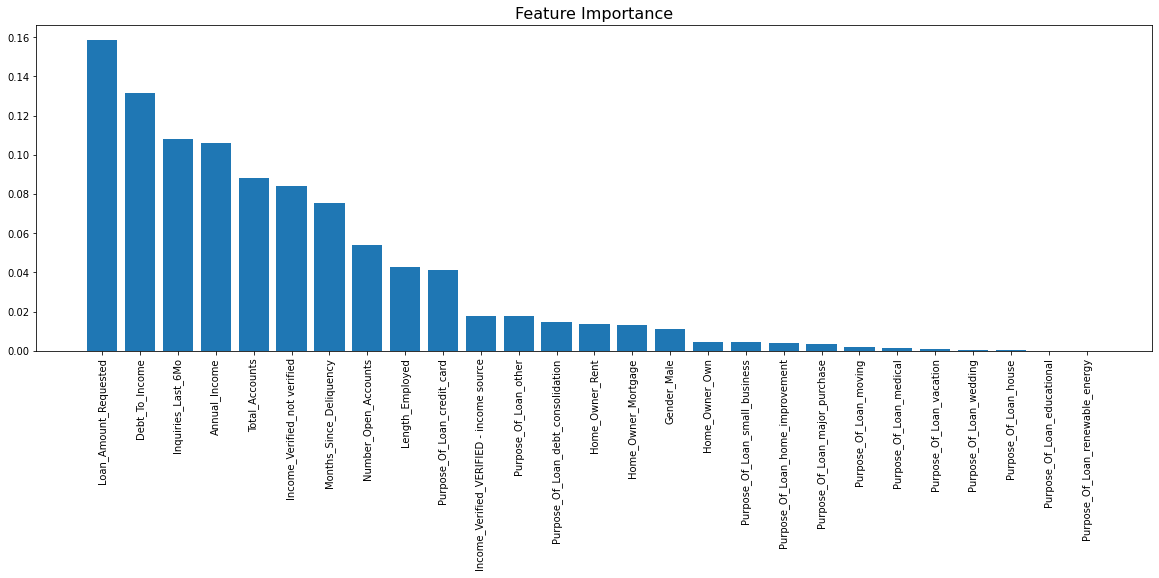

In [113]:
# Plot features importance
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
data_top = df_X.columns.values
plt.figure(figsize=(20, 6))
plt.bar(data_top[indices], importances[indices], align="center")
plt.xticks(rotation=90)
plt.title("Feature Importance", {"fontsize": 16});

## Modeling with new features

In [118]:
features = ['Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Annual_Income', 'Income_Verified', 'Purpose_Of_Loan', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Number_Open_Accounts',
       'Number_Closed_Accounts', 'Number_Years_To_Repay_Debt', 'Gender']

In [119]:
X = trains.loc[:, features].values
y = trains.loc[:, trains.columns == "Interest_Rate"].values.flatten()

X_train, X_test, Y_train, Y_test = train_test_split(
  X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"Original data shapes: {X_train.shape, X_test.shape}")

Original data shapes: ((131447, 13), (32862, 13))


In [120]:
kfold, scores = KFold(n_splits=5, shuffle=True, random_state=0), list()
for train, test in kfold.split(X_train):
    x_train, x_test = X_train[train], X_train[test]
    y_train, y_test = Y_train[train], Y_train[test]
    
    model = CatBoostClassifier(random_state=27, max_depth=4, n_estimators=1000, verbose=500)
    model.fit(x_train, y_train, cat_features=[1, 2, 4, 5, 12])
    preds = model.predict(x_test)
    score = f1_score(y_test, preds, average="weighted")
    scores.append(score)
    print(f"f1_score:{score}")
print("Average: ", sum(scores)/len(scores))

Learning rate set to 0.100331
0:	learn: 1.0811445	total: 75.2ms	remaining: 1m 15s
500:	learn: 0.9110446	total: 38.1s	remaining: 37.9s
999:	learn: 0.8999629	total: 1m 23s	remaining: 0us
f1_score:0.5338242050678729
Learning rate set to 0.100331
0:	learn: 1.0807136	total: 83.7ms	remaining: 1m 23s
500:	learn: 0.9087212	total: 42.1s	remaining: 42s
999:	learn: 0.8975590	total: 1m 23s	remaining: 0us
f1_score:0.5324596630638194
Learning rate set to 0.100331
0:	learn: 1.0810058	total: 97.5ms	remaining: 1m 37s
500:	learn: 0.9115597	total: 42.1s	remaining: 42s
999:	learn: 0.9010577	total: 1m 25s	remaining: 0us
f1_score:0.5358933671653506
Learning rate set to 0.100331
0:	learn: 1.0809558	total: 88.4ms	remaining: 1m 28s
500:	learn: 0.9101262	total: 44.5s	remaining: 44.3s
999:	learn: 0.8996410	total: 1m 28s	remaining: 0us
f1_score:0.5319679106745308
Learning rate set to 0.100331
0:	learn: 1.0808805	total: 100ms	remaining: 1m 40s
500:	learn: 0.9096978	total: 43.7s	remaining: 43.5s
999:	learn: 0.89938

In [121]:
model = CatBoostClassifier(random_state=27, n_estimators=1000, max_depth=4, verbose=500)
model.fit(X_train, Y_train, cat_features=[0, 1, 2, 4, 5, 12])
y_predict = model.predict(X_test)

Learning rate set to 0.10148
0:	learn: 1.0802886	total: 136ms	remaining: 2m 16s
500:	learn: 0.9026088	total: 1m 3s	remaining: 1m 3s
999:	learn: 0.8944974	total: 2m 4s	remaining: 0us


In [122]:
print('Confusion Matrix')
print(confusion_matrix(Y_test, y_predict))
print('Classification Report')
print(classification_report(Y_test, y_predict))
print(f"f1_score:{f1_score(Y_test, y_predict, average='weighted')}")

Confusion Matrix
[[1885 4106  770]
 [1219 9358 3539]
 [ 271 4854 6860]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.56      0.28      0.37      6761
         1.0       0.51      0.66      0.58     14116
         2.0       0.61      0.57      0.59     11985

    accuracy                           0.55     32862
   macro avg       0.56      0.50      0.51     32862
weighted avg       0.56      0.55      0.54     32862

f1_score:0.5405051352745236


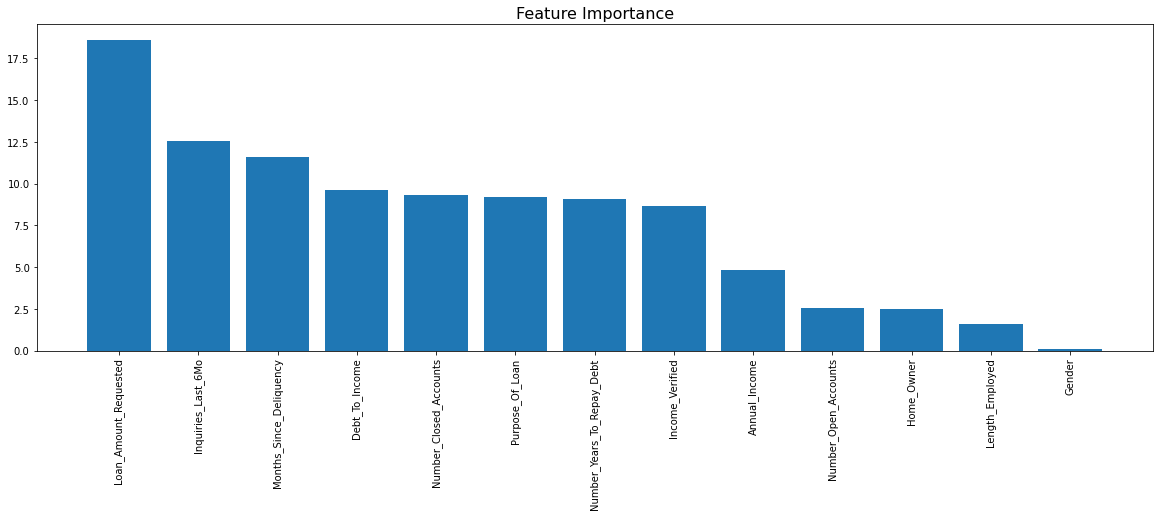

In [123]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
data_top = trains[features].columns.values
plt.figure(figsize=(20, 6))
plt.bar(data_top[indices], importances[indices], align="center")
plt.xticks(rotation=90)
plt.title("Feature Importance", {"fontsize": 16});

<AxesSubplot:>

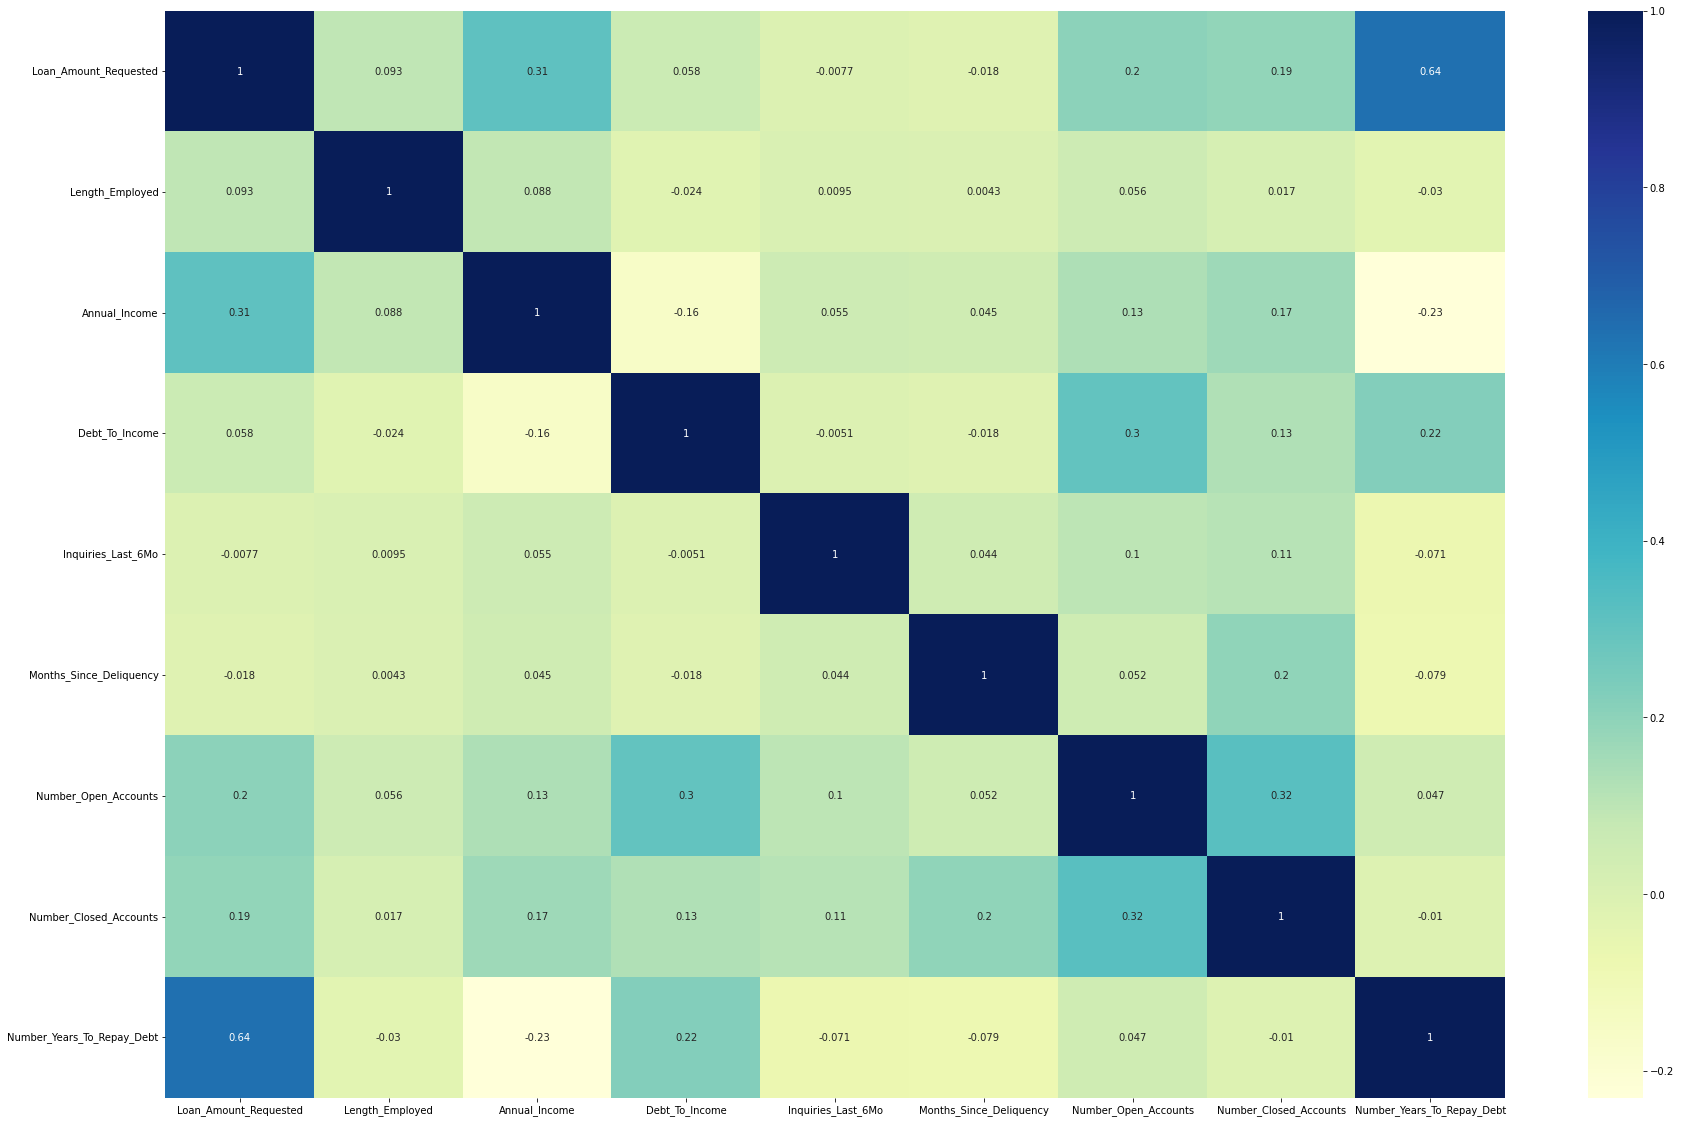

In [124]:
corrMatrix = trains[features].corr()
plt.figure(figsize=(30,20))
sns.heatmap(corrMatrix, annot=True, cmap="YlGnBu")

In [137]:
X = tests.loc[:, features].values
y_pred = model.predict(X)

In [138]:
y_pred.flatten().shape

(109541,)

In [140]:
tests['Interest_Rate'] = y_pred.flatten()
tests['Interest_Rate'] = tests['Interest_Rate']+1

/home/reza/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/reza/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [142]:
trains.to_csv('Final_dataset.csv', index=False)

In [143]:
tests.to_csv('Prediction_results.csv', index=False)

## Modeling with new features and normalization

In [106]:
from sklearn.preprocessing import StandardScaler

In [107]:
features = ['Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Annual_Income', 'Income_Verified', 'Purpose_Of_Loan', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Total_Accounts',
       'Number_Closed_Accounts', 'Number_Years_To_Repay_Debt', 'Gender']
numericals = ['Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Total_Accounts',
       'Number_Closed_Accounts', 'Number_Years_To_Repay_Debt']

In [110]:
X_train_df = trains.copy()
X_test_df = tests.copy()

sc = StandardScaler()
X_train_df[numericals] = sc.fit_transform(X_train_df[numericals])
X_test_df[numericals] = sc.transform(X_test_df[numericals])

In [111]:
X = X_train_df.loc[:, features].values
y = X_train_df.loc[:, trains.columns == "Interest_Rate"].values.flatten()

X_train, X_test, Y_train, Y_test = train_test_split(
  X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"Original data shapes: {X_train.shape, X_test.shape}")

Original data shapes: ((131447, 13), (32862, 13))


In [112]:
kfold, scores = KFold(n_splits=5, shuffle=True, random_state=0), list()
for train, test in kfold.split(X_train):
    x_train, x_test = X_train[train], X_train[test]
    y_train, y_test = Y_train[train], Y_train[test]
    
    model = CatBoostClassifier(random_state=27, max_depth=4, n_estimators=1000, verbose=500)
    model.fit(x_train, y_train, cat_features=[1, 2, 4, 5, 12])
    preds = model.predict(x_test)
    score = f1_score(y_test, preds, average="weighted")
    scores.append(score)
    print(f"f1_score:{score}")
print("Average: ", sum(scores)/len(scores))

Learning rate set to 0.100331
0:	learn: 1.0811445	total: 68.7ms	remaining: 1m 8s
500:	learn: 0.9119905	total: 32.5s	remaining: 32.4s
999:	learn: 0.9009838	total: 1m 7s	remaining: 0us
f1_score:0.5348036694652437
Learning rate set to 0.100331
0:	learn: 1.0807136	total: 69.6ms	remaining: 1m 9s
500:	learn: 0.9097986	total: 37.1s	remaining: 37s
999:	learn: 0.8991115	total: 1m 15s	remaining: 0us
f1_score:0.5311030563549541
Learning rate set to 0.100331
0:	learn: 1.0810058	total: 76.1ms	remaining: 1m 16s
500:	learn: 0.9120956	total: 38.7s	remaining: 38.5s
999:	learn: 0.9016286	total: 1m 18s	remaining: 0us
f1_score:0.5343527821775448
Learning rate set to 0.100331
0:	learn: 1.0809558	total: 74.1ms	remaining: 1m 14s
500:	learn: 0.9115018	total: 39s	remaining: 38.8s
999:	learn: 0.9007817	total: 1m 20s	remaining: 0us
f1_score:0.5299902309462717
Learning rate set to 0.100331
0:	learn: 1.0808805	total: 89.9ms	remaining: 1m 29s
500:	learn: 0.9106231	total: 41.3s	remaining: 41.1s
999:	learn: 0.9000269

In [114]:
model = CatBoostClassifier(random_state=27, n_estimators=1000, max_depth=4, verbose=500)
model.fit(X_train, Y_train, cat_features=[1, 2, 4, 5, 12])
y_predict = model.predict(X_test)

Learning rate set to 0.10148
0:	learn: 1.0808026	total: 115ms	remaining: 1m 55s
500:	learn: 0.9122095	total: 48.8s	remaining: 48.6s
999:	learn: 0.9030094	total: 1m 46s	remaining: 0us


In [115]:
print('Confusion Matrix')
print(confusion_matrix(Y_test, y_predict))
print('Classification Report')
print(classification_report(Y_test, y_predict))
print(f"f1_score:{f1_score(Y_test, y_predict, average='weighted')}")

Confusion Matrix
[[1827 4094  840]
 [1194 9184 3738]
 [ 281 4804 6900]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.55      0.27      0.36      6761
         1.0       0.51      0.65      0.57     14116
         2.0       0.60      0.58      0.59     11985

    accuracy                           0.55     32862
   macro avg       0.55      0.50      0.51     32862
weighted avg       0.55      0.55      0.53     32862

f1_score:0.5342602101262873


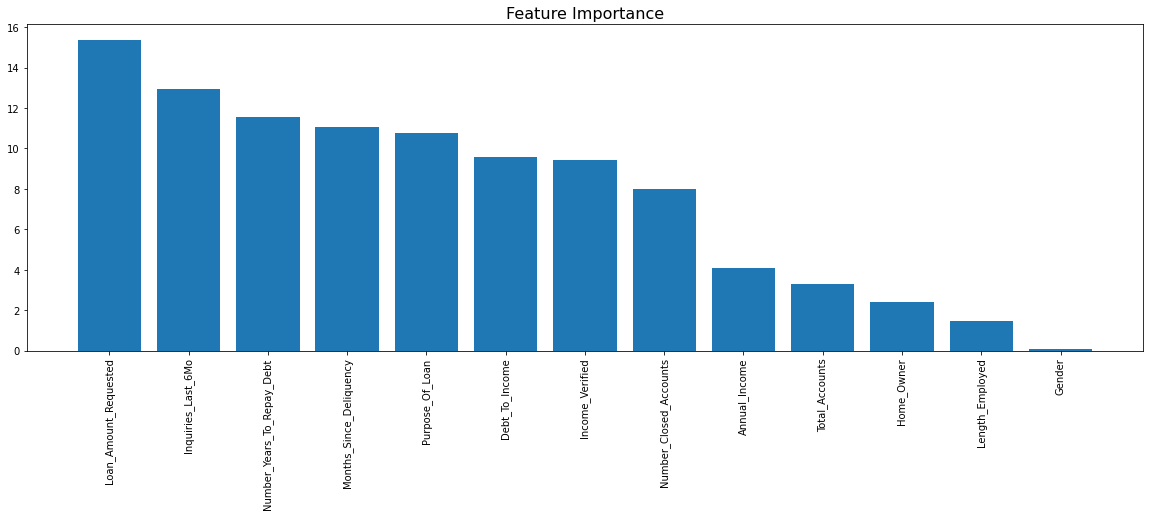

In [116]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
data_top = X_train_df[features].columns.values
plt.figure(figsize=(20, 6))
plt.bar(data_top[indices], importances[indices], align="center")
plt.xticks(rotation=90)
plt.title("Feature Importance", {"fontsize": 16});

<AxesSubplot:>

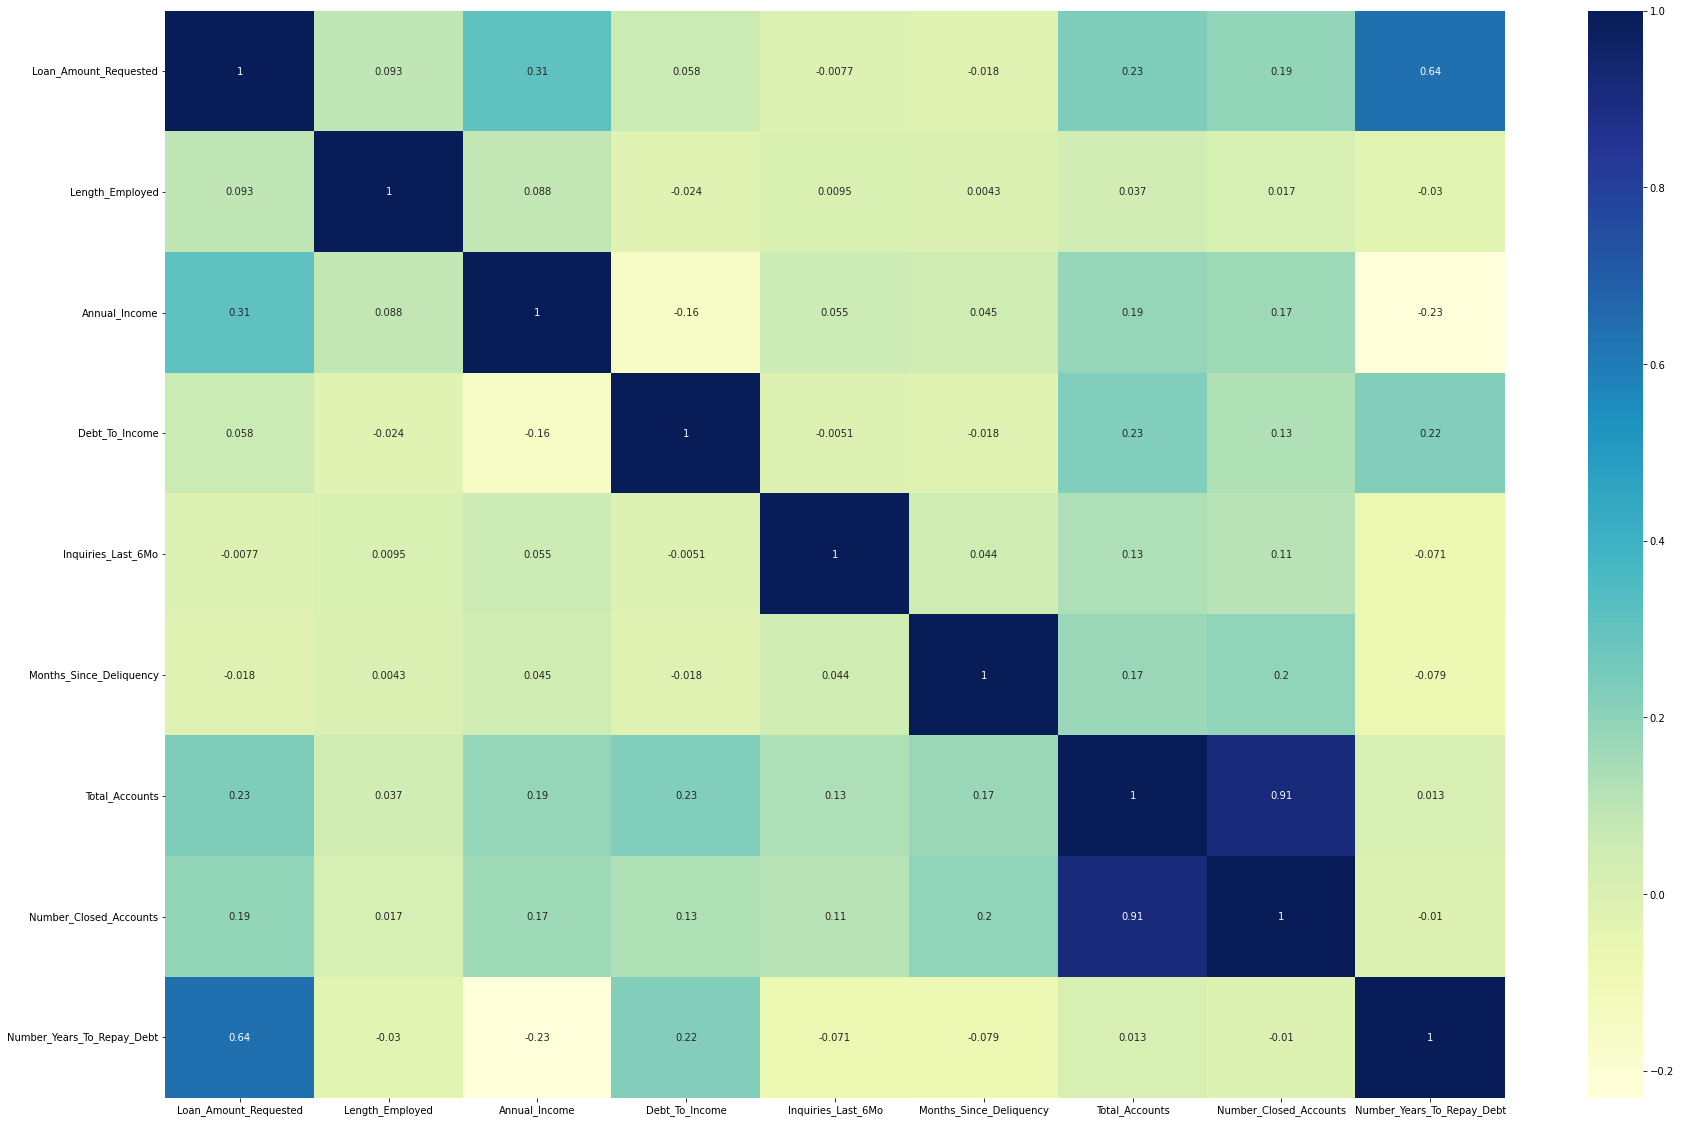

In [117]:
corrMatrix = X_train_df[features].corr()
plt.figure(figsize=(30,20))
sns.heatmap(corrMatrix, annot=True, cmap="YlGnBu")